# LR-ASPP

This notebook is to train and test the performance of LR-ASPP model

# Drive, libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import time

# Import data and split

## DIW

In [3]:
#  When working on Google drive it's easier and faster to unzip all the images on the virtual directory
import zipfile
import os
import time

start = time.time()

zip_file_path = "/content/drive/MyDrive/depth_estimation/DIW/test_200_200.zip"
destination_folder = "DIW/test_200_200/"
os.makedirs(destination_folder, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r')   as zip_ref:
    zip_ref.extractall(destination_folder)

print(f'Images extracted to {destination_folder}')
print("Execution time: ", time.time() - start)

Images extracted to DIW/test_200_200/
Execution time:  60.08748698234558


In [4]:
img_path = destination_folder+"test_200_200/"
os.listdir(img_path)

['test', 'train', 'val']

In [5]:
# The number of images has to be equal to the dataframes size
tr, v, t = img_path + "train/", img_path + "val/", img_path + "test/"
train_paths, val_paths, test_paths = sorted(os.listdir(tr)), sorted(os.listdir(v)), sorted(os.listdir(t))

len(train_paths), len(val_paths), len(test_paths)

(51751, 11089, 11090)

In [6]:
# Importing the train, validation and test dataframes

df_folder = "/content/drive/MyDrive/depth_estimation/DIW/" # Colab
# df_folder = "" # Local

train_df = pd.read_csv(df_folder + "df_train.csv").iloc[:,1:]
val_df = pd.read_csv(df_folder + "df_val.csv").iloc[:,1:]
test_df = pd.read_csv(df_folder + "df_test.csv").iloc[:,1:]

train_df = train_df.sort_values(by=['filename'],ascending=True)
val_df = val_df.sort_values(by=['filename'],ascending=True)
test_df = test_df.sort_values(by=['filename'],ascending=True)

# Print the sizes of the sets
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 51751
Validation set size: 11089
Test set size: 11090


In [ ]:
# Code to show some images
from PIL import Image
img_folder = img_path + "train/"

samples = train_df.sample(10, random_state=16)
samples = train_df.iloc[:10,:]
display(samples)

for index, sample in samples.iterrows():

    # Image path
    path = img_folder + sample['filename']
    # Annotations
    ya, xa, yb, xb, ordinal = sample['y_a'], sample['x_a'], sample['y_b'], sample['x_b'], sample['ordinal']

    image = Image.open(path)
    img = np.array(image)

    # Depth relation
    if ordinal == -1:
        text = "B is closer than A"
    else:
        text = "A is closer than B"

    plt.imshow(img)
    plt.scatter(xa, ya, color="red", marker='x', s=100, label='A')
    plt.scatter(xb, yb, color="green", marker='x', s=100, label='B')
    plt.title("Image " + str(index) + "\n " + text)
    plt.legend()
    plt.axis("off")
    plt.show()

In [ ]:
# Checking files syncronization
# Due to the way the DataLoaders are implemented, the list of images and the annotations dataframes need to be syncronized (corted alhabetically)
train = (train_paths == train_df['filename']).values.astype(int)
val = (val_paths == val_df['filename']).values.astype(int)
test = (test_paths == test_df['filename']).values.astype(int)

train.sum() == len(train), val.sum() == len(val), test.sum() == len(test)

(True, True, True)

### DataLoaders

The DataLoaders will be used as data generators to train and test the model

In [7]:
import torch
from PIL import Image  # Import the Image module from the PIL package
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

# Path to the folder containing images
# image_folder =  "/content/drive/MyDrive/depth_estimation/DIW/test_200_200/test_200_200/" # Colab
image_folder =  img_path # Colab
# image_folder = "/Users/ismas/Downloads/DIW/test_200_200/" # Local

# Define a transformation to be applied to each image
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
])

# Custom dataset class
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, df, transform=None):
        self.folder_path = folder_path
        self.transform = transform

        # List of all image files in the folder
        self.image_files = df['filename'].values
        self.df = df

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Read the image
        image_path = os.path.join(self.folder_path, self.image_files[idx])
        # image = torchvision.io.read_image(image_path)
        image = Image.open(image_path).convert("RGB")  # Ensure the image is in RGB format

        # Take the annotations using the same index
        # label = self.df[self.df['filename']==self.image_files[idx]].values
        label = self.df.iloc[idx, 1:-2].values
        label = np.append(label, idx).astype('float')

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image.permute(1, 2, 0), label

# Create an instance of the custom dataset
train_dataset_diw = CustomImageDataset(image_folder + "train/", train_df, transform=transform)
val_dataset_diw = CustomImageDataset(image_folder + "val/", val_df, transform=transform)
test_dataset_diw = CustomImageDataset(image_folder + "test/", test_df, transform=transform)

# Create a DataLoader for batching and shuffling the data
batch_size = 32
num_workers = 2
train_loader_diw = DataLoader(train_dataset_diw, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)
val_loader_diw = DataLoader(val_dataset_diw, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)
test_loader_diw = DataLoader(test_dataset_diw, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

# Example of usage to show all shapes
i = 0
for train, val, test in zip(train_loader_diw, val_loader_diw, test_loader_diw):

    train_image, train_label = train
    val_image, val_label = val
    test_image, test_label = test
    print(train_image.shape, train_label.shape, val_image.shape, val_label.shape, test_image.shape, test_label.shape)
    i+=1
    if i == 5:
      break

torch.Size([32, 200, 200, 3]) torch.Size([32, 6]) torch.Size([32, 200, 200, 3]) torch.Size([32, 6]) torch.Size([32, 200, 200, 3]) torch.Size([32, 6])
torch.Size([32, 200, 200, 3]) torch.Size([32, 6]) torch.Size([32, 200, 200, 3]) torch.Size([32, 6]) torch.Size([32, 200, 200, 3]) torch.Size([32, 6])
torch.Size([32, 200, 200, 3]) torch.Size([32, 6]) torch.Size([32, 200, 200, 3]) torch.Size([32, 6]) torch.Size([32, 200, 200, 3]) torch.Size([32, 6])
torch.Size([32, 200, 200, 3]) torch.Size([32, 6]) torch.Size([32, 200, 200, 3]) torch.Size([32, 6]) torch.Size([32, 200, 200, 3]) torch.Size([32, 6])
torch.Size([32, 200, 200, 3]) torch.Size([32, 6]) torch.Size([32, 200, 200, 3]) torch.Size([32, 6]) torch.Size([32, 200, 200, 3]) torch.Size([32, 6])


In [ ]:
# Code to plot images showing also the depth relation
def plot_img(img, label, legend = True, id=''):

  # ya, xa, yb, xb, ordinal = row['y_A'], row['x_A'], row['y_B'], row['x_B'], row['ordinal']
  xa, ya, xb, yb, ordinal = label

  if ordinal == 1:
      text = "A is closer than B"
  else:
      text = "B is closer than A"

  plt.imshow(img)
  plt.scatter(xa, ya, color="red", marker='x', s=100, label='A')
  plt.scatter(xb, yb, color="green", marker='x', s=100, label='B')

  if id != '': # id is the id of the image
    id = id + " - "
  plt.title(id + text)
  if legend:
      plt.legend()
  plt.axis("off")
  # plt.show()

[  161    81   153   166     1 50868]
['fa1bfaae837d3b11b4ecfbfb5ad4cc35b7a17de6.jpg' 161 81 153 166 1 200 200]

[ 199   84  135  141   -1 7028]
['1521a8af904bdc1b7e21d4349eb48c4cf862a458.jpg' 199 84 135 141 -1 200 200]

[  93   88   54  166   -1 4198]
['0babaf069d88bc5b89f6100a282dfad4a770ae5f.jpg' 93 88 54 166 -1 200 200]

[   49   150   150   150    -1 49951]
['f417d76cd55b264f52dfed3a41d70217c2bb15ff.jpg' 49 150 150 150 -1 200 200]

[  64  101  135  101    1 6911]
['14be210bf0496ea7ae46df4e280a4493c7ddc8e0.jpg' 64 101 135 101 1 200 200]



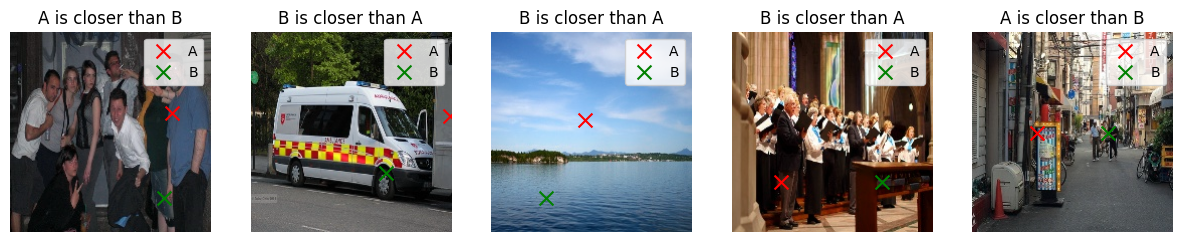

In [ ]:
# Showing some images from the DataLoaders
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    random_index = torch.randint(0, len(train_dataset_diw), (1,)).item()
    image, label = train_dataset_diw[random_index]

    print(label.astype(int))
    print(train_df.iloc[label[-1].astype(int),:].values)
    print()
    image = np.asarray(image*255).astype(np.uint8) # Image converted to int for correct visualization
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.subplot(1,5,i+1)
    plot_img(image, label[:-1])

plt.show()

## NYU

In [3]:
# Import of the arrays with the images and depths
images_path = "/content/drive/MyDrive/depth_estimation/NYU/img_200_200.npy"
depths_path = "/content/drive/MyDrive/depth_estimation/NYU/depth_200_200.npy"

x, y = np.load(images_path), np.load(depths_path)
x.shape, y.shape

((1449, 200, 200, 3), (1449, 200, 200))

In [4]:
# Normalizing depths
y_norm = y.copy()
for i in range(y.shape[0]):
  img = y[i]
  y_norm[i] = (img - np.min(img)) / (np.max(img) - np.min(img))

np.min(y_norm), np.max(y_norm)

y = y_norm

In [5]:
# Checking normalization in the depths
np.min(x), np.max(x), np.min(y), np.max(y)

(0.0, 255.0, 0.0, 1.0)

In [6]:
# Train, validation and test split
# Proportions are 0.7, 0.15, 0.15
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, train_size=0.5)

print("Train shape: ", x_train.shape, y_train.shape)
print("Val   shape: ", x_val.shape, y_val.shape)
print("Test  shape: ", x_test.shape, y_test.shape)

Train shape:  (1014, 200, 200, 3) (1014, 200, 200)
Val   shape:  (217, 200, 200, 3) (217, 200, 200)
Test  shape:  (218, 200, 200, 3) (218, 200, 200)


### DataLoaders

The DataLoaders will be used as data generators to train and test the model

In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert numpy arrays to PyTorch tensors
timages_tensor, tlabels_tensor = torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
vimages_tensor, vlabels_tensor = torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
ttimages_tensor, ttlabels_tensor = torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Create a TensorDataset
train_dataset_nyu = TensorDataset(timages_tensor, tlabels_tensor)
val_dataset_nyu = TensorDataset(vimages_tensor, vlabels_tensor)
test_dataset_nyu = TensorDataset(ttimages_tensor, ttlabels_tensor)

# Create a DataLoader
batch_size = 32
train_loader_nyu = DataLoader(train_dataset_nyu, batch_size=batch_size, shuffle=True, drop_last = True)
val_loader_nyu = DataLoader(val_dataset_nyu, batch_size=batch_size, shuffle=True, drop_last = True)
test_loader_nyu = DataLoader(test_dataset_nyu, batch_size=batch_size, shuffle=True, drop_last = True)

# Iteration to show the shapes
for train, val, test in zip(train_loader_nyu, val_loader_nyu, test_loader_nyu):
  timages, tdepths = train
  vimages, vdepths = train
  ttimages, ttdepths = train

  print(timages.shape, tdepths.shape, vimages.shape, vdepths.shape, ttimages.shape, ttdepths.shape)
  break

del x, y, y_norm, x_train, y_train, x_val, y_val, x_test, y_test

torch.Size([32, 200, 200, 3]) torch.Size([32, 200, 200]) torch.Size([32, 200, 200, 3]) torch.Size([32, 200, 200]) torch.Size([32, 200, 200, 3]) torch.Size([32, 200, 200])


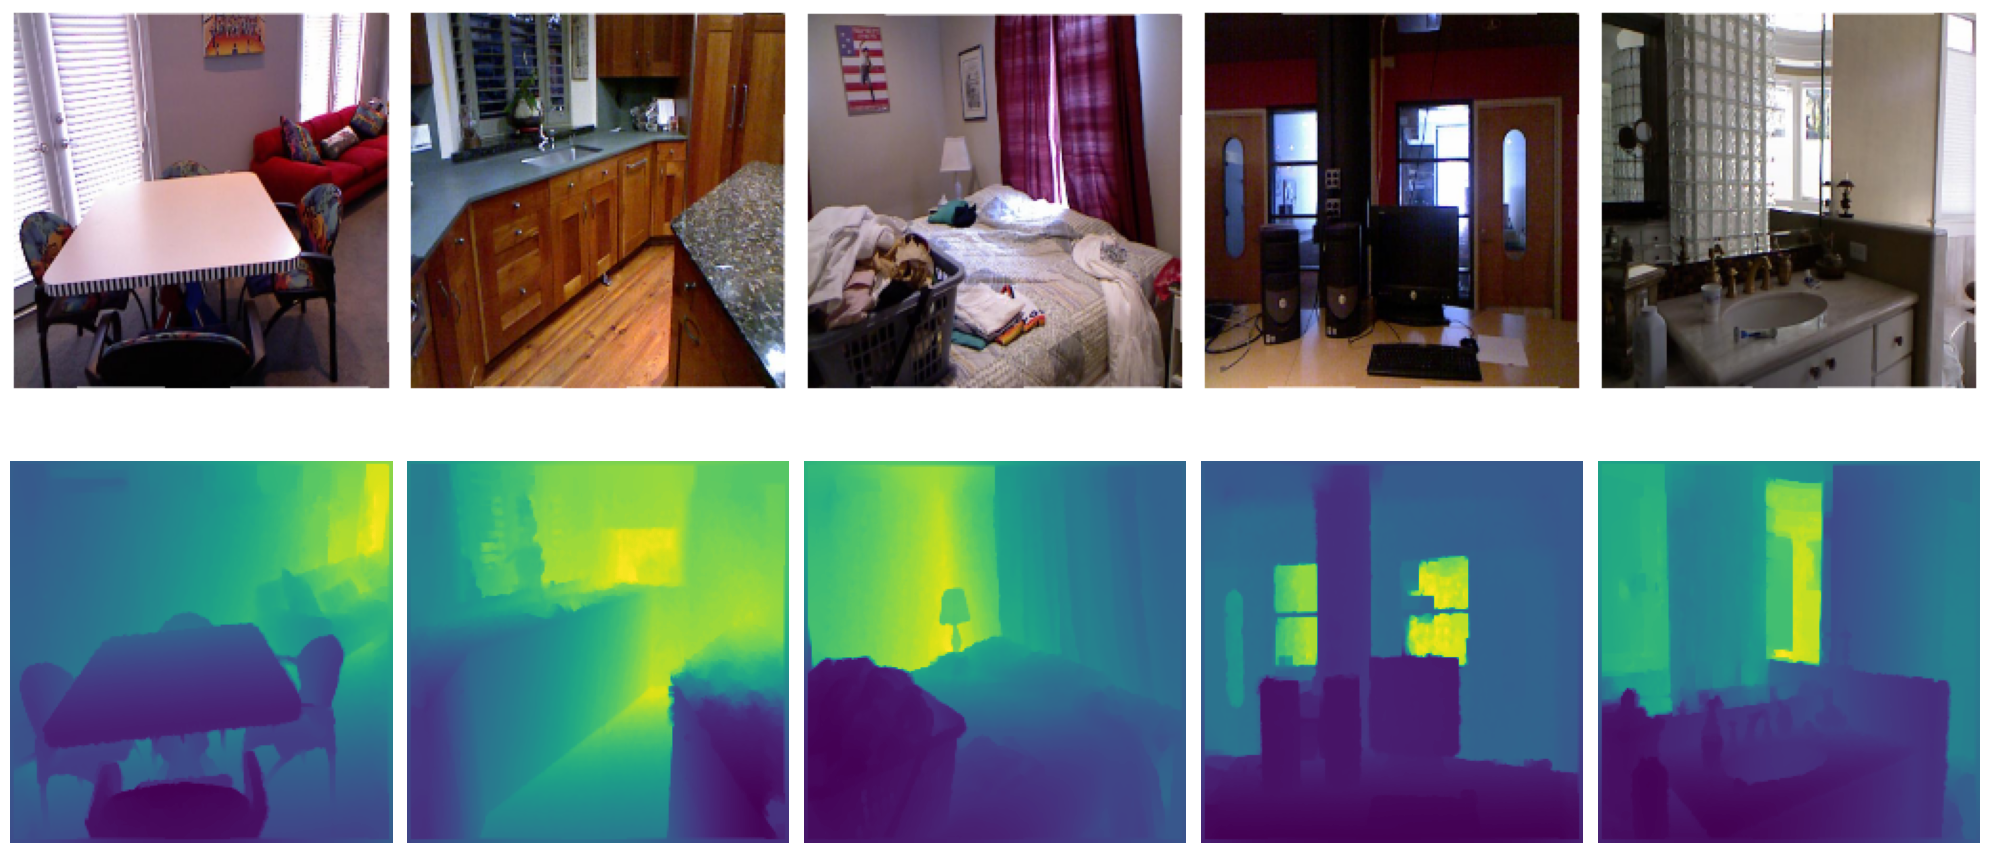

In [ ]:
# Visualizing examples

n_cols = 5

fig, axs = plt.subplots(2, n_cols, figsize=(20, 10))

for i in range(n_cols):

    axs[0, i].imshow(timages[i].numpy().astype(np.uint8))
    axs[0, i].axis('off')
    axs[1, i].imshow(tdepths[i])
    axs[1, i].axis('off')

plt.tight_layout()

# Show the plot
plt.show()

# LRASPP

https://pytorch.org/vision/stable/models/generated/torchvision.models.segmentation.lraspp_mobilenet_v3_large.html#torchvision.models.segmentation.LRASPP_MobileNet_V3_Large_Weights

In [8]:
from torchvision.models.segmentation import lraspp_mobilenet_v3_large, LRASPP_MobileNet_V3_Large_Weights

weights = LRASPP_MobileNet_V3_Large_Weights.DEFAULT
preprocess = weights.transforms()
model = lraspp_mobilenet_v3_large(weights=weights)
# model.eval()

Downloading: "https://download.pytorch.org/models/lraspp_mobilenet_v3_large-d234d4ea.pth" to /root/.cache/torch/hub/checkpoints/lraspp_mobilenet_v3_large-d234d4ea.pth
100%|██████████| 12.5M/12.5M [00:00<00:00, 61.6MB/s]


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class CustomModel(nn.Module):
    def __init__(self, pretrained_model):
        super(CustomModel, self).__init__()

        # Assuming pretrained_model is your pretrained model
        self.pretrained_model = pretrained_model

        # Additional layers
        self.extra_layer_1 = nn.Conv2d(21, 1, kernel_size=3, padding='same', stride=1)
        # self.extra_bn_1 = nn.BatchNorm2d(32)
        # self.extra_layer_2 = nn.Conv2d(32, 64, kernel_size=3, padding=0, stride=2)
        # self.extra_bn_2 = nn.BatchNorm2d(64)
        # self.extra_layer_3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, output_padding=1)
        # self.extra_bn_3 = nn.BatchNorm2d(32)
        # self.extra_layer_4 = nn.Conv2d(32, 1, kernel_size=3, padding='same')

    def forward(self, x):
        # Forward pass through the pretrained model
        pretrained_output = self.pretrained_model(x)['out']

        # Apply additional layers to the extracted output
        output = self.extra_layer_1(pretrained_output)
        output = F.relu(output)
        # output = self.extra_bn_1(output)
        # output = self.extra_layer_2(output)
        # output = F.relu(output)
        # output = self.extra_bn_2(output)
        # output = self.extra_layer_3(output)
        # output = F.relu(output)
        # output = self.extra_bn_3(output)
        # output = self.extra_layer_4(output)
        # output = F.relu(output)

        return output

complete_model = CustomModel(model)

print("Trainable layers")
for p in complete_model.named_parameters():
  if 'extra' in p[0]:
    p[1].requires_grad = True
    print(p[0])
  else:
    p[1].requires_grad = False

print()
print("Total parameters: ", sum(p.numel() for p in complete_model.parameters()))
print("Trainable parameters: ", sum(p.numel() for p in complete_model.parameters() if p.requires_grad))

Trainable layers
extra_layer_1.weight
extra_layer_1.bias

Total parameters:  3221728
Trainable parameters:  190


In [ ]:
preprocess

SemanticSegmentation(
    resize_size=[520]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [10]:
import torch
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from PIL import Image

class SemanticSegmentationTransform:
    def __init__(self):
        self.resize_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize([520], interpolation=InterpolationMode.BILINEAR),
        ])

        self.tensor_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __call__(self, tensor):
        # Permute dimensions from (32, 200, 200, 3) to (32, 3, 200, 200)
        tensor = tensor.permute(0, 3, 1, 2)

        # Apply resize transformation
        resized_images = [self.resize_transform(tensor[i]) for i in range(tensor.size(0))]

        # Apply tensor transformation
        preprocessed_tensor = torch.stack([self.tensor_transform(img) for img in resized_images])

        return preprocessed_tensor

semantic_seg_transform = SemanticSegmentationTransform()

## Training NYU

In [11]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
from tempfile import TemporaryDirectory

cudnn.benchmark = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [32]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25, save_path=None):
  since = time.time()

  # Create a temporary directory to save training checkpoints
  with TemporaryDirectory() as tempdir:
    if save_path:
      best_model_params_path = save_path
    else:
      best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_loss = 1000.0
    train_loss, val_loss = [], []

    for epoch in range(num_epochs):
      print(f'Epoch {epoch}/{num_epochs - 1}')

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
        if phase == 'train':
          model.train()  # Set model to training mode
        else:
          model.eval()   # Set model to evaluate mode

        model = model.to(device)
        running_loss = 0.0

        # Iterate over data.
        n = 0
        for inputs, labels in dataloaders[phase]:
          inputs = semantic_seg_transform(inputs).to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward
          # track history if only in train
          # with torch.set_grad_enabled(phase == 'train'):
          if phase == 'train':

            for p in model.named_parameters():
              if 'extra' in p[0]:
                p[1].requires_grad = True
                # print(p[0])
              else:
                p[1].requires_grad = False

            outputs = model(inputs)
            outputs = torch.squeeze(outputs, dim=1)
            # _, preds = torch.max(outputs, 1)
            outputs = transforms.functional.resize(outputs, labels.shape[1:], antialias=True)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

          else: # Validation steps
            with torch.no_grad():

              outputs = model(inputs)
              outputs = torch.squeeze(outputs, dim=1)
              # _, preds = torch.max(outputs, 1)
              outputs = transforms.functional.resize(outputs, labels.shape[1:], antialias=True)
              loss = criterion(outputs, labels)

          # statistics
          running_loss += loss.item() * inputs.size(0)

          n += 1
          if n == dataset_sizes[phase]:
            break

        epoch_loss = running_loss / dataset_sizes[phase]

        if phase == 'train':
          scheduler.step()
          train_loss.append(epoch_loss)
        else:
          val_loss.append(epoch_loss)

        print(f'  {phase} Loss: {epoch_loss:.4f}')

        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
          best_loss = epoch_loss
          torch.save(model.state_dict(), best_model_params_path)

      print()

      time_elapsed = time.time() - since
      print(f'* Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
      print(f'* Best val loss: {best_loss:4f}')
      print('-' * 10)

      # load best model weights
      model.load_state_dict(torch.load(best_model_params_path))
  return model, (train_loss, val_loss)

In [27]:
dataloaders = {"train": train_loader_nyu, "val": val_loader_nyu}
steps = {"train": len(train_dataset_nyu), "val": len(val_dataset_nyu)}

dataloaders, steps

({'train': <torch.utils.data.dataloader.DataLoader at 0x7d9c386cbd30>,
  'val': <torch.utils.data.dataloader.DataLoader at 0x7d9c386cbe50>},
 {'train': 1014, 'val': 217})

In [ ]:
model_ft = complete_model.to(device)

criterion = nn.MSELoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.001, momentum=0.9)
optimizer_ft = optim.AdamW([p[1] for p in model_ft.named_parameters() if 'extra' in p[0]], lr=0.001, weight_decay=0.02)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

dataloaders = {"train": train_loader_nyu, "val": val_loader_nyu}
steps = {"train": len(train_dataset_nyu), "val": len(val_dataset_nyu)}
# steps = {"train": 10, "val": 5}

save_path = "/content/drive/MyDrive/depth_estimation/lraspp_nyu_1layer.pt"

In [33]:
model_ft, hist = train_model(model_ft, dataloaders, steps, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100, save_path=save_path)

Epoch 0/99
  train Loss: 0.2149
  val Loss: 0.1419

* Training complete in 0m 23s
* Best val loss: 0.141857
----------
Epoch 1/99
  train Loss: 0.1323
  val Loss: 0.0838

* Training complete in 0m 43s
* Best val loss: 0.083803
----------
Epoch 2/99
  train Loss: 0.0803
  val Loss: 0.0618

* Training complete in 1m 4s
* Best val loss: 0.061836
----------
Epoch 3/99
  train Loss: 0.0691
  val Loss: 0.0615

* Training complete in 1m 25s
* Best val loss: 0.061513
----------
Epoch 4/99
  train Loss: 0.0699
  val Loss: 0.0611

* Training complete in 1m 46s
* Best val loss: 0.061117
----------
Epoch 5/99
  train Loss: 0.0703
  val Loss: 0.0597

* Training complete in 2m 7s
* Best val loss: 0.059670
----------
Epoch 6/99
  train Loss: 0.0674
  val Loss: 0.0587

* Training complete in 2m 28s
* Best val loss: 0.058651
----------
Epoch 7/99
  train Loss: 0.0662
  val Loss: 0.0585

* Training complete in 2m 49s
* Best val loss: 0.058506
----------
Epoch 8/99
  train Loss: 0.0657
  val Loss: 0.0595

In [ ]:
for inputs, labels in dataloaders["val"]:
  inputs = semantic_seg_transform(inputs).to(device)
  labels = labels.to(device)

  outputs = model_ft(inputs)

  outputs = torch.squeeze(outputs, dim=1)
  # _, preds = torch.max(outputs, 1)
  outputs = transforms.functional.resize(outputs, labels.shape[1:], antialias=True)

  loss = criterion(outputs, labels)
  break

loss.item() * inputs.size(0)/32

0.06921624392271042

In [ ]:
for i in range(32):

  plt.subplot(1,2,1)
  plt.imshow(inputs[i].permute(1,2,0).cpu())
  plt.title(str(i))
  plt.axis("off")
  plt.subplot(1,2,2)
  plt.imshow(outputs[i].detach().cpu().numpy(), cmap='gray')
  plt.axis("off")
  plt.show()

## Train DIW

In [15]:
model_ft.load_state_dict(torch.load('/content/drive/MyDrive/depth_estimation/lraspp_nyu_1layer.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [12]:
import torch
import torch.nn.functional as F

def custom_loss(y_pred, y_true):
    # y_pred (batch_size, 1, width, height)
    # y_true (batch_size, 5) -> x_A, y_A, x_B, y_B, ordinal
    # print(y_true.shape, y_pred.shape)

    # Extract the coordinates and ordinal value from y_true
    coord1, coord2, ordinal = y_true[:, :2].long(), y_true[:, 2:4].long(), y_true[:, 4]

    # Extract the values of the two pixels using the coordinates
    pixel1 = y_pred[torch.arange(y_pred.size(0)), coord1[:, 1], coord1[:, 0]]
    pixel2 = y_pred[torch.arange(y_pred.size(0)), coord2[:, 1], coord2[:, 0]]

    # Loss based on the ordinal value for each batch element
    losses = torch.where(ordinal == 1,
                         torch.log(1 + torch.exp(-pixel1 + pixel2)),
                         torch.log(1 + torch.exp(pixel1 - pixel2)))

    # Take the mean of the losses across the batch
    loss = torch.mean(losses)

    return loss

In [16]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25, save_path=None):
  since = time.time()

  # Create a temporary directory to save training checkpoints
  with TemporaryDirectory() as tempdir:
    if save_path:
      best_model_params_path = save_path
    else:
      best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_loss = 1000.0
    train_loss, val_loss = [], []

    for epoch in range(num_epochs):
      print(f'Epoch {epoch}/{num_epochs - 1}')

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
        if phase == 'train':
          model.train()  # Set model to training mode
        else:
          model.eval()   # Set model to evaluate mode

        model = model.to(device)
        running_loss = 0.0

        # Iterate over data.
        n = 0
        for inputs, labels in dataloaders[phase]:
          inputs = semantic_seg_transform(inputs).to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward
          # track history if only in train
          # with torch.set_grad_enabled(phase == 'train'):
          if phase == 'train':

            for p in model.named_parameters():
              if 'extra' in p[0]:
                p[1].requires_grad = True
                # print(p[0])
              else:
                p[1].requires_grad = False

            outputs = model(inputs)
            outputs = torch.squeeze(outputs, dim=1)
            # _, preds = torch.max(outputs, 1)
            outputs = transforms.functional.resize(outputs, inputs.shape[2], antialias=True)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

          else: # Validation steps
            with torch.no_grad():

              outputs = model(inputs)
              outputs = torch.squeeze(outputs, dim=1)
              # _, preds = torch.max(outputs, 1)
              outputs = transforms.functional.resize(outputs, inputs.shape[2], antialias=True)
              loss = criterion(outputs, labels)

          # statistics
          running_loss += loss.item() * inputs.size(0)

          n += 1
          if n == dataset_sizes[phase]:
            break

        epoch_loss = running_loss / dataset_sizes[phase]

        if phase == 'train':
          scheduler.step()
          train_loss.append(epoch_loss)
        else:
          val_loss.append(epoch_loss)

        print(f'  {phase} Loss: {epoch_loss:.4f}')

        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
          best_loss = epoch_loss
          torch.save(model.state_dict(), best_model_params_path)

      print()

      time_elapsed = time.time() - since
      print(f'* Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
      print(f'* Best val loss: {best_loss:4f}')
      print('-' * 10)

      # load best model weights
      model.load_state_dict(torch.load(best_model_params_path))
  return model, (train_loss, val_loss)

In [13]:
model_ft = complete_model.to(device)

criterion = custom_loss

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.001, momentum=0.9)
optimizer_ft = optim.AdamW([p[1] for p in model_ft.named_parameters() if 'extra' in p[0]], lr=0.001, weight_decay=0.02)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

dataloaders = {"train": train_loader_diw, "val": val_loader_diw}
steps = {"train": len(train_dataset_diw), "val": len(val_dataset_diw)}
# steps = {"train": 10, "val": 5}

save_path = "/content/drive/MyDrive/depth_estimation/lraspp_diw_1layer.pt"

In [ ]:
model_ft, hist = train_model(model_ft, dataloaders, steps, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10, save_path=save_path)

# Testing

## WKDR

In [ ]:
# WKDR
def get_depth_relation(img, p1, p2):
    """
    * img: redicted depth image
    * p1, p2: (x,y) coords of the A and B points respectively
    * threshold: threshold value for the equal depth
    """

    pixel1, pixel2 = img[p1], img[p2]

    if pixel1 > pixel2: # B is closer than A
        return 0
    else:               # A is closer than B
        return 1

def compute_accuracy_dataset(data_loader, iters, verbose = True):
    """
    * dataset: data_loader, train, validation or test
    * iters: number of iterations for the tf.dataset
    * verbose: print results at the end
    """

    performance = []

    count = 0

    for images, targets in data_loader:
        print(count, end="-")

        # if count % 10 == 0:
          # print(count, end="-")
        img, mask = images.permute(0,3,1,2)*255, targets
        img = transforms.functional.resize(img, 224, antialias=True).to(device)
        mask = mask.to(device)
        predictions = model(img).view(32, 224, 224).detach()

        for i in range(batch_size):

            x_a, y_a, x_b, y_b, ordinal,_ = targets[i].numpy().astype('int')

            true_relation = 1 if ordinal == 1 else 0 # 1 -> A is closer | 0 -> B is closer

            if predictions[i, y_a, x_a] > predictions[i, y_b, x_b]:
                # B is closer than A
                pred_relation = 0
            else:
                # A is closer than B
                pred_relation = 1

            performance.append(true_relation == pred_relation)

        del img, mask, predictions
        count += 1
        if count == iters:
            print()
            break

    if verbose:
      print(f'Accuracy over {len(performance)} elements: {sum(performance)/len(performance)}')

    return performance

In [ ]:
# Accuracy

print("***** Train results *****")
compute_accuracy_dataset(train_loader_diw, len(train_df) // batch_size, verbose=True)
print("***** Validation results *****")
compute_accuracy_dataset(val_loader_diw, len(val_df) // batch_size, verbose=True)
print("***** Test results *****")
compute_accuracy_dataset(test_loader_diw, len(test_df) // batch_size, verbose=True)

## DIW

In [16]:
def plot_img(img, row, legend = True, id=''):

  # ya, xa, yb, xb, ordinal = row['y_A'], row['x_A'], row['y_B'], row['x_B'], row['ordinal']
  xa, ya, xb, yb, ordinal = row[0], row[1], row[2], row[3], row[4]

  if ordinal == 1:
      text = "A is closer than B"
  else:
      text = "B is closer than A"

  plt.imshow(img)
  plt.scatter(xa, ya, color="red", marker='x', s=100, label='A')
  plt.scatter(xb, yb, color="blue", marker='x', s=100, label='B')

  if id != '':
    id = id + " - "
  plt.title(id + text)
  if legend:
      plt.legend()
  plt.axis("off")
  # plt.show()

In [33]:
# Showing results
data = "test"

if data == "train":
  dataloader = train_loader_diw
elif data == "val":
  dataloader = val_loader_diw
elif data == "test":
  dataloader = test_loader_diw

model.eval()
os.makedirs("preds/", exist_ok=True)

for inputs, labels in dataloader:

  # img, mask = img.permute(0,3,1,2)*255, mask
  # img = transforms.functional.resize(img, 224, antialias=True).to(device)
  # mask = mask.to(device)
  # preds = model(img).view(32, 224, 224).detach()
  # loss = loss_fn(preds,mask)

  inputs = semantic_seg_transform(inputs).to(device)
  labels = labels.to(device)

  outputs = model_ft(inputs)
  outputs = torch.squeeze(outputs, dim=1)
  # _, preds = torch.max(outputs, 1)
  outputs = transforms.functional.resize(outputs, inputs.shape[2], antialias=True)
  loss = criterion(outputs, labels)
  outputs= outputs.detach()

  for i in range(32):
    plt.subplot(1,2,1)
    img = inputs[i].permute(1,2,0).cpu()
    img = (img - torch.min(img)) / (torch.max(img) - torch.min(img))
    img = cv2.cvtColor((img*255).numpy().astype(np.uint8), cv2.COLOR_BGR2RGB)
    plot_img(img, labels[i], id=str(i))

    plt.subplot(1,2,2)
    plt.imshow(outputs[i])
    plt.axis("off")

    a, b = labels[i][:2].numpy().astype('int'), labels[i][2:4].numpy().astype('int')
    values = np.asarray([outputs[i,a[1], a[0]], outputs[i,b[1], b[0]]])
    if values[0] > values[1]:
      title = "B is closer than A"
    else:
      title = "A is closer than B"
    # title = "A: " + str(np.round(values[0], 4)) + " B: "+ str(np.round(values[1], 4))
    plt.title(title)
    plt.scatter(a[0], a[1], color="red", marker='x', s=100, label='A')
    plt.scatter(b[0], b[1], color="blue", marker='x', s=100, label='B')
    plt.legend()
    plt.savefig("preds/diw_"+data+"_"+str(i)+".jpg")
    plt.show()
    # break
  break
del inputs, labels, outputs, loss

Output hidden; open in https://colab.research.google.com to view.

## NYU

In [32]:
# Showing results
data = "test"

if data == "train":
  dataloader = train_loader_nyu
elif data == "val":
  dataloader = val_loader_nyu
elif data == "test":
  dataloader = test_loader_nyu

model.eval()
os.makedirs("preds/", exist_ok=True)

for inputs, labels in dataloader:

  inputs = semantic_seg_transform(inputs).to(device)
  labels = labels.to(device)

  outputs = model_ft(inputs)
  outputs = torch.squeeze(outputs, dim=1)
  # _, preds = torch.max(outputs, 1)
  outputs = transforms.functional.resize(outputs, labels.shape[1:], antialias=True)
  loss = criterion(outputs, labels)

  for i in range(inputs.shape[0]):
    img = inputs[i].permute(1,2,0).cpu()
    img = (img - torch.min(img)) / (torch.max(img) - torch.min(img))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title(data + " - " + str(i))
    plt.axis("off")

    norm = labels[i]
    norm = (norm - torch.min(norm)) / (torch.max(norm) - torch.min(norm))
    plt.subplot(1,3,2)
    plt.imshow(norm.cpu())
    plt.title("Depth map")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(outputs[i].detach().cpu())
    plt.title("Predicted depth")
    plt.axis("off")
    plt.savefig("preds/nyu_"+data+"_"+str(i)+".jpg")
    plt.show()
  break
del img, labels, outputs, loss

Output hidden; open in https://colab.research.google.com to view.

In [34]:
# Code to download the folder with all the predictions
import zipfile

def zip_folder(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arc_name = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname=arc_name)

# Example usage:
folder_to_zip = '/content/preds/'
output_zip_path = 'LR_preds.zip'

zip_folder(folder_to_zip, output_zip_path)